# Phase 1A: Exploratory Data Analysis

Analyze 3 seasons of historical NBA data to identify fantasy value drivers.

**Prerequisites:** Run `python scripts/fetch_historical_data.py` first to populate `data/`.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.data.data_loader import load_dataset

sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

In [2]:
# Load combined dataset
df = load_dataset()
if df is None:
    raise FileNotFoundError('Run scripts/fetch_historical_data.py first')

print(f'Shape: {df.shape}')
print(f'Seasons: {sorted(df["SEASON_YEAR"].unique())}')
print(f'Players: {df["PLAYER_ID"].nunique():,}')
print(f'Date range: {df["game_date_parsed"].min().date()} to {df["game_date_parsed"].max().date()}')
print()
df.head()

Shape: (77672, 81)
Seasons: ['2021-22', '2022-23', '2023-24']
Players: 818
Date range: 2021-10-19 to 2024-04-20



,PLAYER_NAME,PLAYER_ID,TEAM_ABBREVIATION,SEASON_YEAR,GAME_DATE,MATCHUP,WL,MIN,PTS,REB,...,blk_roll_15,tov_roll_15,min_roll_15,fpts_std_15,fpts_trend_3v10,fpts_trend_5v15,fpts_last_game_diff,is_hot_streak,season_phase,career_game_count
0,Precious Achiuwa,achiupr01,TOR,2021-22,"Oct 20, 2021",TOR vs. WAS,L,18.5,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,early,1
1,Precious Achiuwa,achiupr01,TOR,2021-22,"Oct 22, 2021",TOR @ BOS,W,24.8,0,15,...,0.0,1.000000,18.500000,NaN,0.000000,0.0,7.500000,False,early,2
2,Precious Achiuwa,achiupr01,TOR,2021-22,"Oct 23, 2021",TOR vs. DAL,L,33.4,0,12,...,0.0,0.500000,21.650000,5.303301,0.000000,0.0,0.250000,False,early,3
3,Precious Achiuwa,achiupr01,TOR,2021-22,"Oct 25, 2021",TOR vs. CHI,L,28.6,0,11,...,0.0,0.666667,25.566667,3.752777,0.000000,0.0,-2.333333,False,early,4
4,Precious Achiuwa,achiupr01,TOR,2021-22,"Oct 27, 2021",TOR vs. IND,W,27.5,0,6,...,0.0,1.000000,26.325000,3.278719,1.083333,0.0,-3.250000,True,early,5


## 1. Fantasy Points Distribution

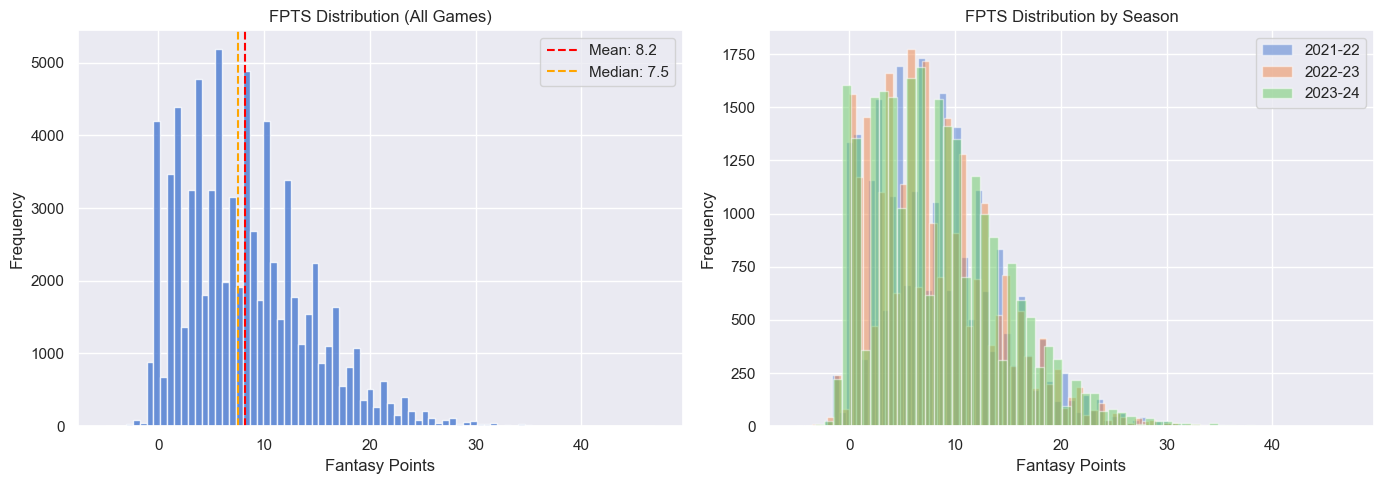

count    77672.000000
mean         8.211112
std          6.005783
min         -5.000000
25%          3.500000
50%          7.500000
75%         12.000000
max         47.000000
Name: fpts, dtype: float64


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall FPTS distribution
axes[0].hist(df['fpts'].dropna(), bins=80, edgecolor='white', alpha=0.8)
axes[0].axvline(df['fpts'].mean(), color='red', linestyle='--', label=f'Mean: {df["fpts"].mean():.1f}')
axes[0].axvline(df['fpts'].median(), color='orange', linestyle='--', label=f'Median: {df["fpts"].median():.1f}')
axes[0].set_xlabel('Fantasy Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title('FPTS Distribution (All Games)')
axes[0].legend()

# FPTS by season
for season in sorted(df['SEASON_YEAR'].unique()):
    season_data = df[df['SEASON_YEAR'] == season]['fpts']
    axes[1].hist(season_data, bins=60, alpha=0.5, label=season)
axes[1].set_xlabel('Fantasy Points')
axes[1].set_ylabel('Frequency')
axes[1].set_title('FPTS Distribution by Season')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/fpts_distribution.png', bbox_inches='tight')
plt.show()

print(df['fpts'].describe())

## 2. Top Players by Mean FPTS

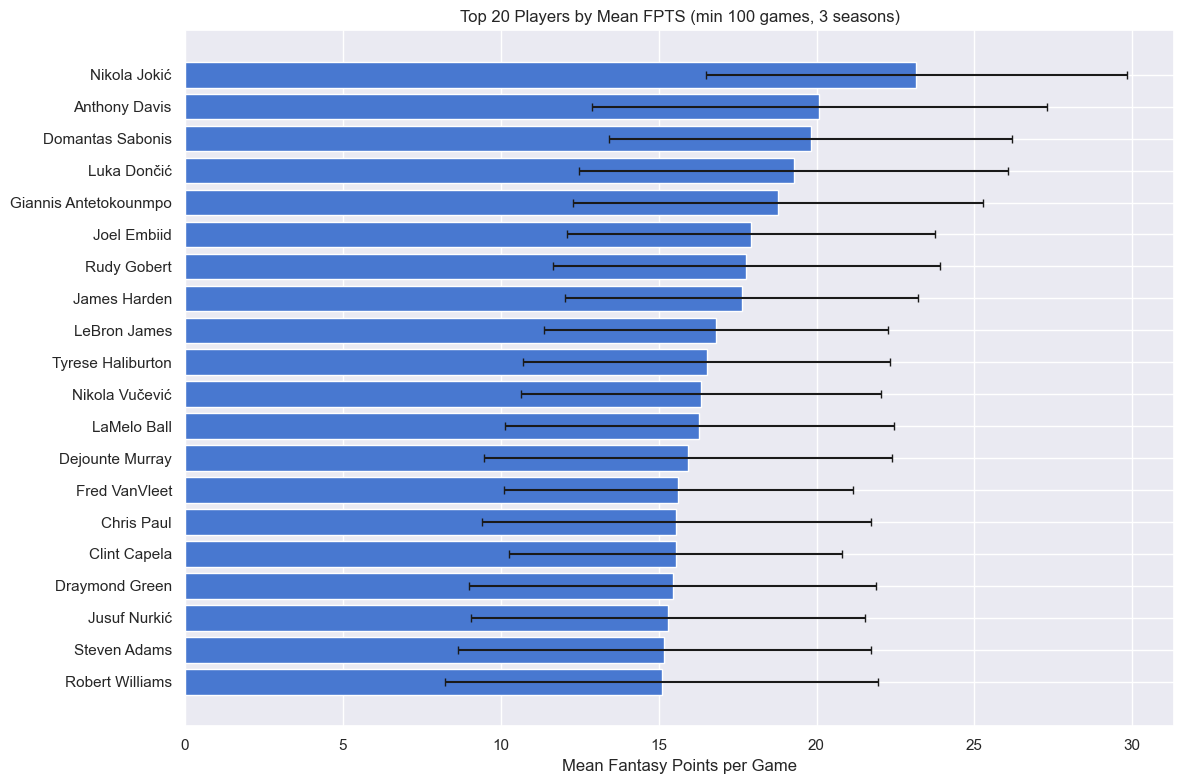

'          PLAYER_NAME  mean_fpts  std_fpts  games  seasons\n         Nikola Jokić  23.164384  6.667077    219        3\n        Anthony Davis  20.085714  7.207999    175        3\n     Domantas Sabonis  19.809955  6.376098    221        3\n          Luka Dončić  19.282051  6.793526    195        3\nGiannis Antetokounmpo  18.770936  6.488031    203        3\n          Joel Embiid  17.932203  5.822754    177        3\n          Rudy Gobert  17.769953  6.131318    213        3\n         James Harden  17.638462  5.591443    195        3\n         LeBron James  16.822581  5.450834    186        3\n    Tyrese Haliburton  16.517857  5.825535    196        3\n       Nikola Vučević  16.341304  5.694921    230        3\n          LaMelo Ball  16.291667  6.150790    132        3\n      Dejounte Murray  15.918552  6.457918    221        3\n        Fred VanVleet  15.620773  5.532771    207        3\n           Chris Paul  15.564171  6.152292    187        3\n         Clint Capela  15.548837  5.274

In [4]:
# Top 20 players by mean FPTS (min 100 games across all seasons)
player_stats = df.groupby(['PLAYER_ID', 'PLAYER_NAME']).agg(
    mean_fpts=('fpts', 'mean'),
    std_fpts=('fpts', 'std'),
    games=('fpts', 'count'),
    seasons=('SEASON_YEAR', 'nunique'),
).reset_index()

top_20 = player_stats[player_stats['games'] >= 100].nlargest(20, 'mean_fpts')

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(top_20)), top_20['mean_fpts'], xerr=top_20['std_fpts'],
               capsize=3, color=sns.color_palette('muted')[0])
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['PLAYER_NAME'])
ax.set_xlabel('Mean Fantasy Points per Game')
ax.set_title('Top 20 Players by Mean FPTS (min 100 games, 3 seasons)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

top_20[['PLAYER_NAME', 'mean_fpts', 'std_fpts', 'games', 'seasons']].to_string(index=False)

## 3. Rolling Average Behavior

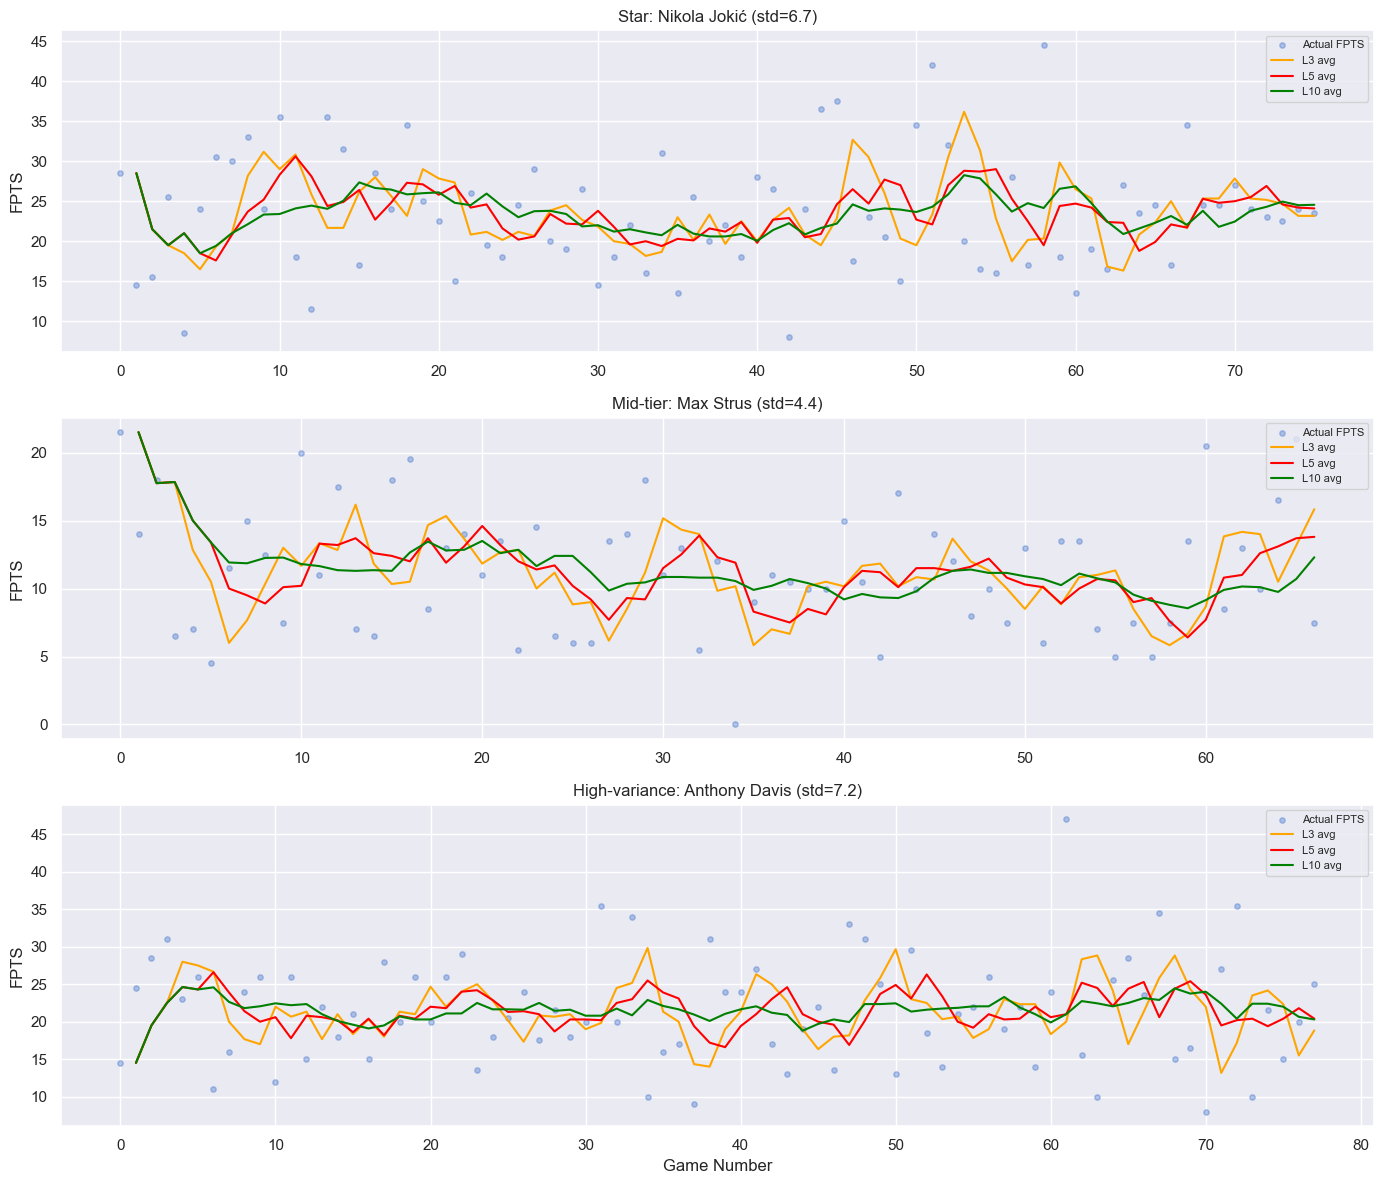

In [5]:
# Pick 3 representative players: top scorer, mid-tier, high-variance
qualified = player_stats[player_stats['games'] >= 100]
star = qualified.nlargest(1, 'mean_fpts').iloc[0]
mid = qualified.iloc[(qualified['mean_fpts'] - qualified['mean_fpts'].median()).abs().argsort()[:1]].iloc[0]
volatile = qualified.nlargest(1, 'std_fpts').iloc[0]

sample_players = [star, mid, volatile]
labels = ['Star', 'Mid-tier', 'High-variance']

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

for ax, player, label in zip(axes, sample_players, labels):
    pdata = df[(df['PLAYER_ID'] == player['PLAYER_ID']) &
              (df['SEASON_YEAR'] == df['SEASON_YEAR'].max())].copy()
    pdata = pdata.sort_values('game_date_parsed')

    ax.scatter(range(len(pdata)), pdata['fpts'], s=15, alpha=0.4, label='Actual FPTS')
    for window, color in [(3, 'orange'), (5, 'red'), (10, 'green')]:
        col = f'fpts_roll_{window}'
        if col in pdata.columns:
            ax.plot(range(len(pdata)), pdata[col], label=f'L{window} avg', color=color, linewidth=1.5)
    ax.set_title(f'{label}: {player["PLAYER_NAME"]} (std={player["std_fpts"]:.1f})')
    ax.set_ylabel('FPTS')
    ax.legend(loc='upper right', fontsize=8)

axes[-1].set_xlabel('Game Number')
plt.tight_layout()
plt.show()

## 4. Trend Predictiveness

Correlation of rolling/trend features with actual FPTS:
fpts_roll_10       0.626499
fpts_roll_5        0.610265
fpts_roll_3        0.586305
fpts_trend_5v15    0.053047
fpts_trend_3v10    0.045445



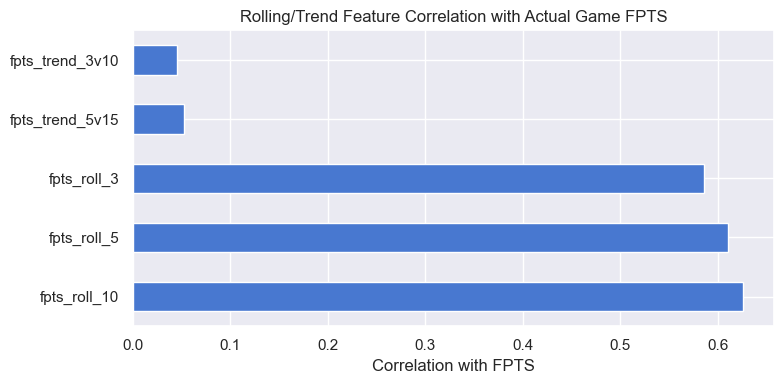

In [6]:
# Does the trend predict next-game performance?
trend_cols = ['fpts_trend_3v10', 'fpts_trend_5v15', 'fpts_roll_3', 'fpts_roll_5', 'fpts_roll_10']
existing_cols = [c for c in trend_cols if c in df.columns]

corr_with_fpts = df[existing_cols + ['fpts']].corr()['fpts'].drop('fpts').sort_values(ascending=False)
print('Correlation of rolling/trend features with actual FPTS:')
print(corr_with_fpts.to_string())
print()

fig, ax = plt.subplots(figsize=(8, 4))
corr_with_fpts.plot(kind='barh', ax=ax)
ax.set_xlabel('Correlation with FPTS')
ax.set_title('Rolling/Trend Feature Correlation with Actual Game FPTS')
plt.tight_layout()
plt.show()

## 5. Home vs Away Effect

Home mean FPTS: 8.31 (n=38,915)
Away mean FPTS: 8.11 (n=38,757)
Difference: 0.20
T-test: t=4.565, p=0.0000
Significant at 0.05: True


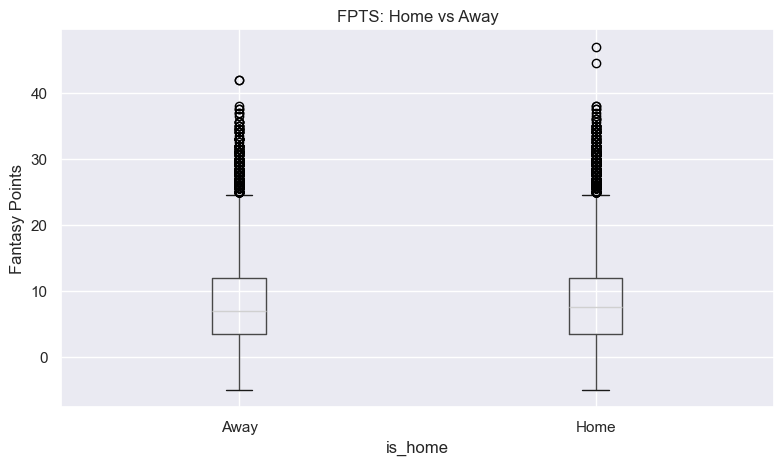

In [7]:
home = df[df['is_home'] == True]['fpts']
away = df[df['is_home'] == False]['fpts']

print(f'Home mean FPTS: {home.mean():.2f} (n={len(home):,})')
print(f'Away mean FPTS: {away.mean():.2f} (n={len(away):,})')
print(f'Difference: {home.mean() - away.mean():.2f}')

t_stat, p_val = stats.ttest_ind(home.dropna(), away.dropna())
print(f'T-test: t={t_stat:.3f}, p={p_val:.4f}')
print(f'Significant at 0.05: {p_val < 0.05}')

fig, ax = plt.subplots(figsize=(8, 5))
df.boxplot(column='fpts', by='is_home', ax=ax)
ax.set_xticklabels(['Away', 'Home'])
ax.set_title('FPTS: Home vs Away')
ax.set_ylabel('Fantasy Points')
plt.suptitle('')
plt.tight_layout()
plt.show()

## 6. Back-to-Back Impact

In [8]:
b2b = df[df['is_back_to_back'] == True]['fpts']
non_b2b = df[df['is_back_to_back'] == False]['fpts']

print(f'B2B mean FPTS: {b2b.mean():.2f} (n={len(b2b):,})')
print(f'Non-B2B mean FPTS: {non_b2b.mean():.2f} (n={len(non_b2b):,})')
print(f'B2B penalty: {b2b.mean() - non_b2b.mean():.2f}')

t_stat, p_val = stats.ttest_ind(b2b.dropna(), non_b2b.dropna())
print(f'T-test: t={t_stat:.3f}, p={p_val:.4f}')
print(f'Significant at 0.05: {p_val < 0.05}')

B2B mean FPTS: 8.61 (n=10,918)
Non-B2B mean FPTS: 8.15 (n=66,754)
B2B penalty: 0.47
T-test: t=7.545, p=0.0000
Significant at 0.05: True


## 7. Rest Day Patterns

                 mean  count       std
rest_bucket                           
1            8.613024  10918  5.895677
2            8.699300  41307  5.936851
3            8.600832  11172  6.035402
4            7.463716   4134  6.193500
5            5.586588   8425  5.589428



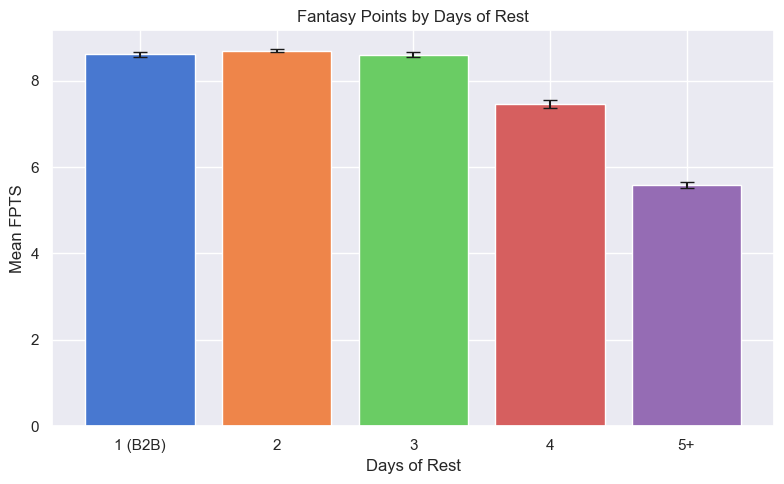

In [9]:
# FPTS by days of rest (cap at 5+)
rest_df = df[df['days_rest'].notna()].copy()
rest_df['rest_bucket'] = rest_df['days_rest'].clip(upper=5).astype(int)
rest_df.loc[rest_df['days_rest'] >= 5, 'rest_bucket'] = 5

rest_means = rest_df.groupby('rest_bucket')['fpts'].agg(['mean', 'count', 'std'])
print(rest_means)
print()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(rest_means.index, rest_means['mean'], yerr=rest_means['std'] / np.sqrt(rest_means['count']),
       capsize=5, color=sns.color_palette('muted'))
ax.set_xticks(rest_means.index)
ax.set_xticklabels(['1 (B2B)', '2', '3', '4', '5+'])
ax.set_xlabel('Days of Rest')
ax.set_ylabel('Mean FPTS')
ax.set_title('Fantasy Points by Days of Rest')
plt.tight_layout()
plt.show()

## 8. Opponent Defense Impact

In [10]:
if 'opp_def_pts' in df.columns:
    opp_cols = [c for c in df.columns if c.startswith('opp_def_')]
    corr_opp = df[opp_cols + ['fpts']].corr()['fpts'].drop('fpts').sort_values(ascending=False)
    print('Correlation of opponent defense features with FPTS:')
    print(corr_opp.to_string())
    print()

    # FPTS vs top-5 defense vs bottom-5 defense
    opp_median = df['opp_def_pts'].median()
    strong_def = df[df['opp_def_pts'] <= df['opp_def_pts'].quantile(0.2)]['fpts']
    weak_def = df[df['opp_def_pts'] >= df['opp_def_pts'].quantile(0.8)]['fpts']
    print(f'FPTS vs strong defense (bottom 20% pts allowed): {strong_def.mean():.2f}')
    print(f'FPTS vs weak defense (top 20% pts allowed): {weak_def.mean():.2f}')
    print(f'Difference: {weak_def.mean() - strong_def.mean():.2f}')

    t_stat, p_val = stats.ttest_ind(strong_def.dropna(), weak_def.dropna())
    print(f'T-test: t={t_stat:.3f}, p={p_val:.4f}')
else:
    print('Opponent defense columns not found in dataset')

Opponent defense columns not found in dataset


## 9. Advanced Stats as Predictors

In [11]:
adv_cols = [c for c in df.columns if c.startswith('adv_')]
if adv_cols:
    corr_adv = df[adv_cols + ['fpts']].corr()['fpts'].drop('fpts').sort_values(ascending=False)
    print('Correlation of advanced stats with FPTS:')
    print(corr_adv.to_string())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    if 'adv_usg_pct' in df.columns:
        player_avg = df.groupby('PLAYER_ID').agg(
            mean_fpts=('fpts', 'mean'), usg=('adv_usg_pct', 'first')
        ).dropna()
        axes[0].scatter(player_avg['usg'], player_avg['mean_fpts'], s=5, alpha=0.3)
        axes[0].set_xlabel('Usage Rate')
        axes[0].set_ylabel('Mean FPTS')
        axes[0].set_title('Usage Rate vs Fantasy Points')

    if 'adv_ts_pct' in df.columns:
        player_avg = df.groupby('PLAYER_ID').agg(
            mean_fpts=('fpts', 'mean'), ts=('adv_ts_pct', 'first')
        ).dropna()
        axes[1].scatter(player_avg['ts'], player_avg['mean_fpts'], s=5, alpha=0.3)
        axes[1].set_xlabel('True Shooting %')
        axes[1].set_ylabel('Mean FPTS')
        axes[1].set_title('True Shooting vs Fantasy Points')

    plt.tight_layout()
    plt.show()
else:
    print('No advanced stat columns found')

No advanced stat columns found


## 10. Feature Correlation Heatmap

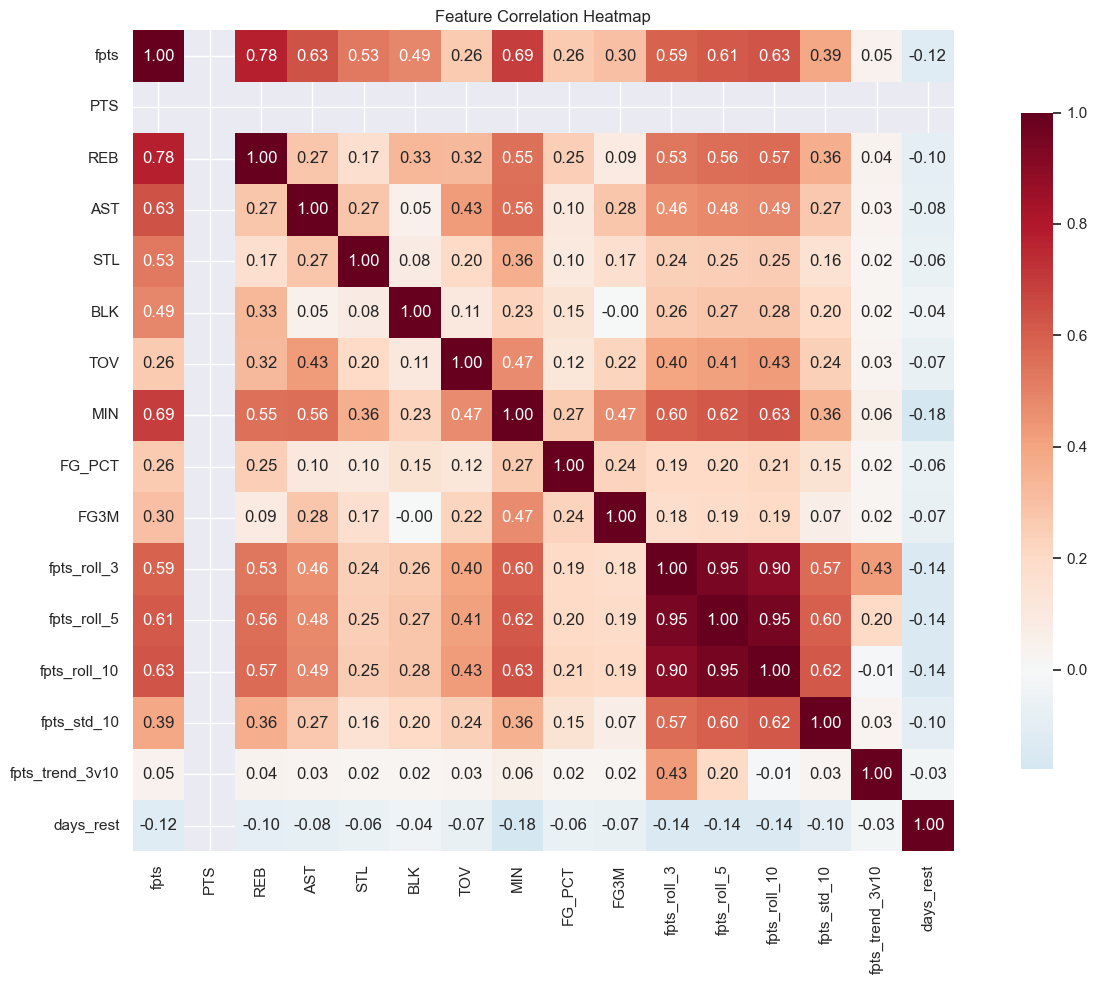

In [12]:
# Select top numeric features for heatmap
feature_cols = [
    'fpts', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'MIN', 'FG_PCT', 'FG3M',
    'fpts_roll_3', 'fpts_roll_5', 'fpts_roll_10',
    'fpts_std_10', 'fpts_trend_3v10',
    'days_rest',
]
# Add advanced/opponent cols if they exist
for c in ['adv_usg_pct', 'adv_ts_pct', 'adv_pace', 'opp_def_pts', 'opp_def_fg_pct']:
    if c in df.columns:
        feature_cols.append(c)

existing_features = [c for c in feature_cols if c in df.columns]
corr_matrix = df[existing_features].corr()

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../data/correlation_heatmap.png', bbox_inches='tight')
plt.show()

## 11. Missing Data Audit

In [13]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_report = pd.DataFrame({'count': missing, 'pct': missing_pct})
missing_nonzero = missing_report[missing_report['count'] > 0].sort_values('pct', ascending=False)

print(f'Columns with missing data: {len(missing_nonzero)} / {len(df.columns)}')
print()
if len(missing_nonzero) > 0:
    print(missing_nonzero.to_string())
else:
    print('No missing data!')

Columns with missing data: 41 / 81

                     count     pct
NBA_FANTASY_PTS      77672  100.00
fpts_std_10           3399    4.38
fpts_std_15           3399    4.38
fpts_std_5            3399    4.38
fpts_std_3            3399    4.38
days_rest             1716    2.21
fpts_roll_3           1716    2.21
pts_roll_3            1716    2.21
reb_roll_3            1716    2.21
tov_roll_3            1716    2.21
blk_roll_3            1716    2.21
stl_roll_3            1716    2.21
ast_roll_3            1716    2.21
reb_roll_5            1716    2.21
ast_roll_5            1716    2.21
fpts_roll_5           1716    2.21
min_roll_3            1716    2.21
blk_roll_5            1716    2.21
tov_roll_5            1716    2.21
min_roll_5            1716    2.21
fpts_roll_10          1716    2.21
pts_roll_10           1716    2.21
reb_roll_10           1716    2.21
stl_roll_5            1716    2.21
pts_roll_5            1716    2.21
stl_roll_10           1716    2.21
ast_roll_10        

## 12. Season Phase Analysis

                   mean       std  count
season_phase                            
early          7.155432  5.837537  29640
mid            8.586094  5.994188  37552
late           9.885193  6.001324   9124
final_stretch  9.637906  5.896444   1356



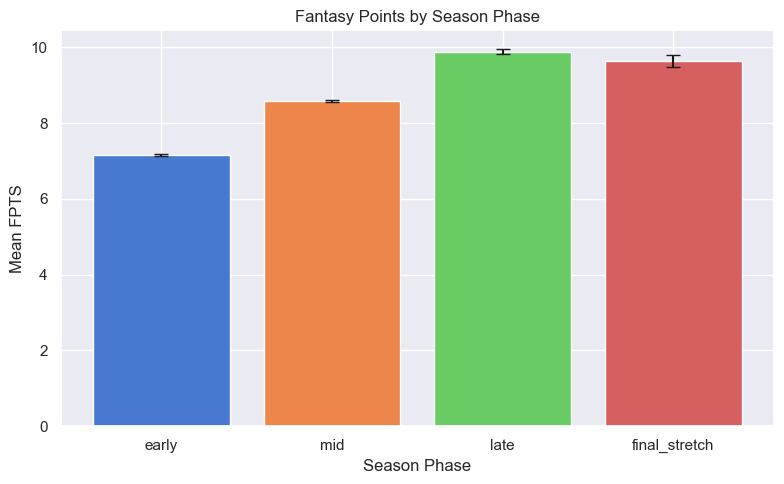

In [14]:
if 'season_phase' in df.columns:
    phase_order = ['early', 'mid', 'late', 'final_stretch']
    phase_stats = df.groupby('season_phase')['fpts'].agg(['mean', 'std', 'count'])
    phase_stats = phase_stats.reindex(phase_order)
    print(phase_stats)
    print()

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(range(len(phase_stats)), phase_stats['mean'],
           yerr=phase_stats['std'] / np.sqrt(phase_stats['count']),
           capsize=5, color=sns.color_palette('muted'))
    ax.set_xticks(range(len(phase_stats)))
    ax.set_xticklabels(phase_order)
    ax.set_xlabel('Season Phase')
    ax.set_ylabel('Mean FPTS')
    ax.set_title('Fantasy Points by Season Phase')
    plt.tight_layout()
    plt.show()

## 13. Summary & Key Insights

**Fill in after running all cells:**

- Most predictive rolling window: _____
- Home advantage effect: _____ FPTS (significant: yes/no)
- Back-to-back penalty: _____ FPTS (significant: yes/no)
- Opponent defense impact: _____ FPTS difference (strong vs weak)
- Most correlated advanced stat: _____
- Key non-obvious finding: _____